In [4]:
import requests
import pandas as pd
import json

![Params](nmdc_api_params.png)

GET
/dataset/{startyear}/{cruiseid}/{platform}

In [ ]:
api_url = 'http://underway-api.hi.no/apis/nmdapi/underway/v1'
startyear = '2021'
cruiseid = '2021052'
r = requests.get(f'{api_url}/dataset/{startyear}/{cruiseid}/9998', headers={"accept":"application/json"})
with open('leg2_data.json', 'w', encoding='utf-8') as f:
    json.dump(r.json(), f, ensure_ascii=False, indent=4)

In [5]:
f = open('leg1_data.json',)

data = json.load(f)

sensors = data['sensor']
for sensor in sensors:
    unit = sensor['unit']
    metadata = sensor['custommetadata']
    displayname = metadata[4]
    name = displayname['customvalue']
    data = sensor['timeseriesdata']
    #names.append(name)
    
    data = { 'unit' : unit, 'sensor' : name, 'data': data }
    json.dumps(data)
    
    with open(f'Leg2/{name}.json', 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

KeyboardInterrupt: 

## Prepare dataframes

In [37]:
def prep_df(file):
    f = open(file)
    data = json.load(f)
    name = data['sensor']
    df = pd.json_normalize(data['data'])
    df = df.set_index('dataid')
    df = df.drop(columns=['sensortimestamp', 'geolocation'])
    df = df.rename(columns={'sensorvalue':name})
    
    return df

rel_sensors = ['FerryBox.C3_CDOMFluorescence.json', 'FerryBox.C3_Temperature.json', 'FerryBox.C3_CHLAFluorescence.json',
               'FerryBox.C3_Turbidity.json','FerryBox.Optode_Concentration.json','FerryBox.Optode_Saturation.json', 'FerryBox.SBE45_Conductivity.json', 
               'FerryBox.SBE45_Salinity.json', 'NMEA.AirPressure.json', 'NMEA.Humidity.json', 'PCO2.atm_cond.json', 'PCO2.CO2_umm.json',
               'PCO2.equ_cond.json', 'PCO2.H2O_mmm.json']

prev_df = pd.DataFrame(columns=['dataid']) #empty dataframe with column dataid
for sensor in rel_sensors:
    df = prep_df(f'Leg1/{sensor}')
    new_df = pd.merge(df,prev_df,on='dataid', how="outer")
    prev_df = new_df
    
new_df
    

,dataid,PCO2.H2O_mmm,PCO2.equ_cond,PCO2.CO2_umm,PCO2.atm_cond,NMEA.Humidity,NMEA.AirPressure,FerryBox.SBE45_Salinity,FerryBox.SBE45_Conductivity,FerryBox.Optode_Saturation,FerryBox.Optode_Concentration,FerryBox.C3_Turbidity,FerryBox.C3_CHLAFluorescence,FerryBox.C3_Temperature,FerryBox.C3_CDOMFluorescence
0,2021-09-16T10:00:00,-0.73,9.92,0.270000,9.96,79.733330,1014.344971,0.225,0.058,93.010002,195.050003,1113.660034,0.21,38.180000,-0.07
1,2021-09-16T10:11:00,-0.76,9.92,-0.270000,9.96,79.157143,1014.417114,0.225,0.058,93.000000,194.789993,1034.589966,0.23,38.240002,-0.02
2,2021-09-16T10:13:00,-0.76,9.92,-0.370000,9.96,78.716667,1014.409973,0.225,0.058,93.000000,194.759995,1041.930054,0.24,38.240002,0.10
3,2021-09-16T10:23:00,-0.79,9.92,217.119995,9.96,79.628571,1014.369995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-09-16T10:31:00,-0.80,9.92,414.339996,9.96,81.166664,1014.421692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48025,2021-10-02T18:37:00,NaN,NaN,NaN,NaN,NaN,NaN,0.021,0.003,87.139999,177.830002,536.659973,-0.48,40.009998,-0.33
48026,2021-10-02T18:38:00,NaN,NaN,NaN,NaN,NaN,NaN,0.021,0.003,87.110001,177.770004,532.260010,-0.49,40.009998,-0.07
48027,2021-10-02T18:39:00,NaN,NaN,NaN,NaN,NaN,NaN,0.021,0.003,87.089996,177.740005,519.039978,-0.46,40.009998,-0.07
48028,2021-10-02T18:40:00,NaN,NaN,NaN,NaN,NaN,NaN,0.021,0.003,87.080002,177.710007,532.750000,-0.49,40.009998,0.00


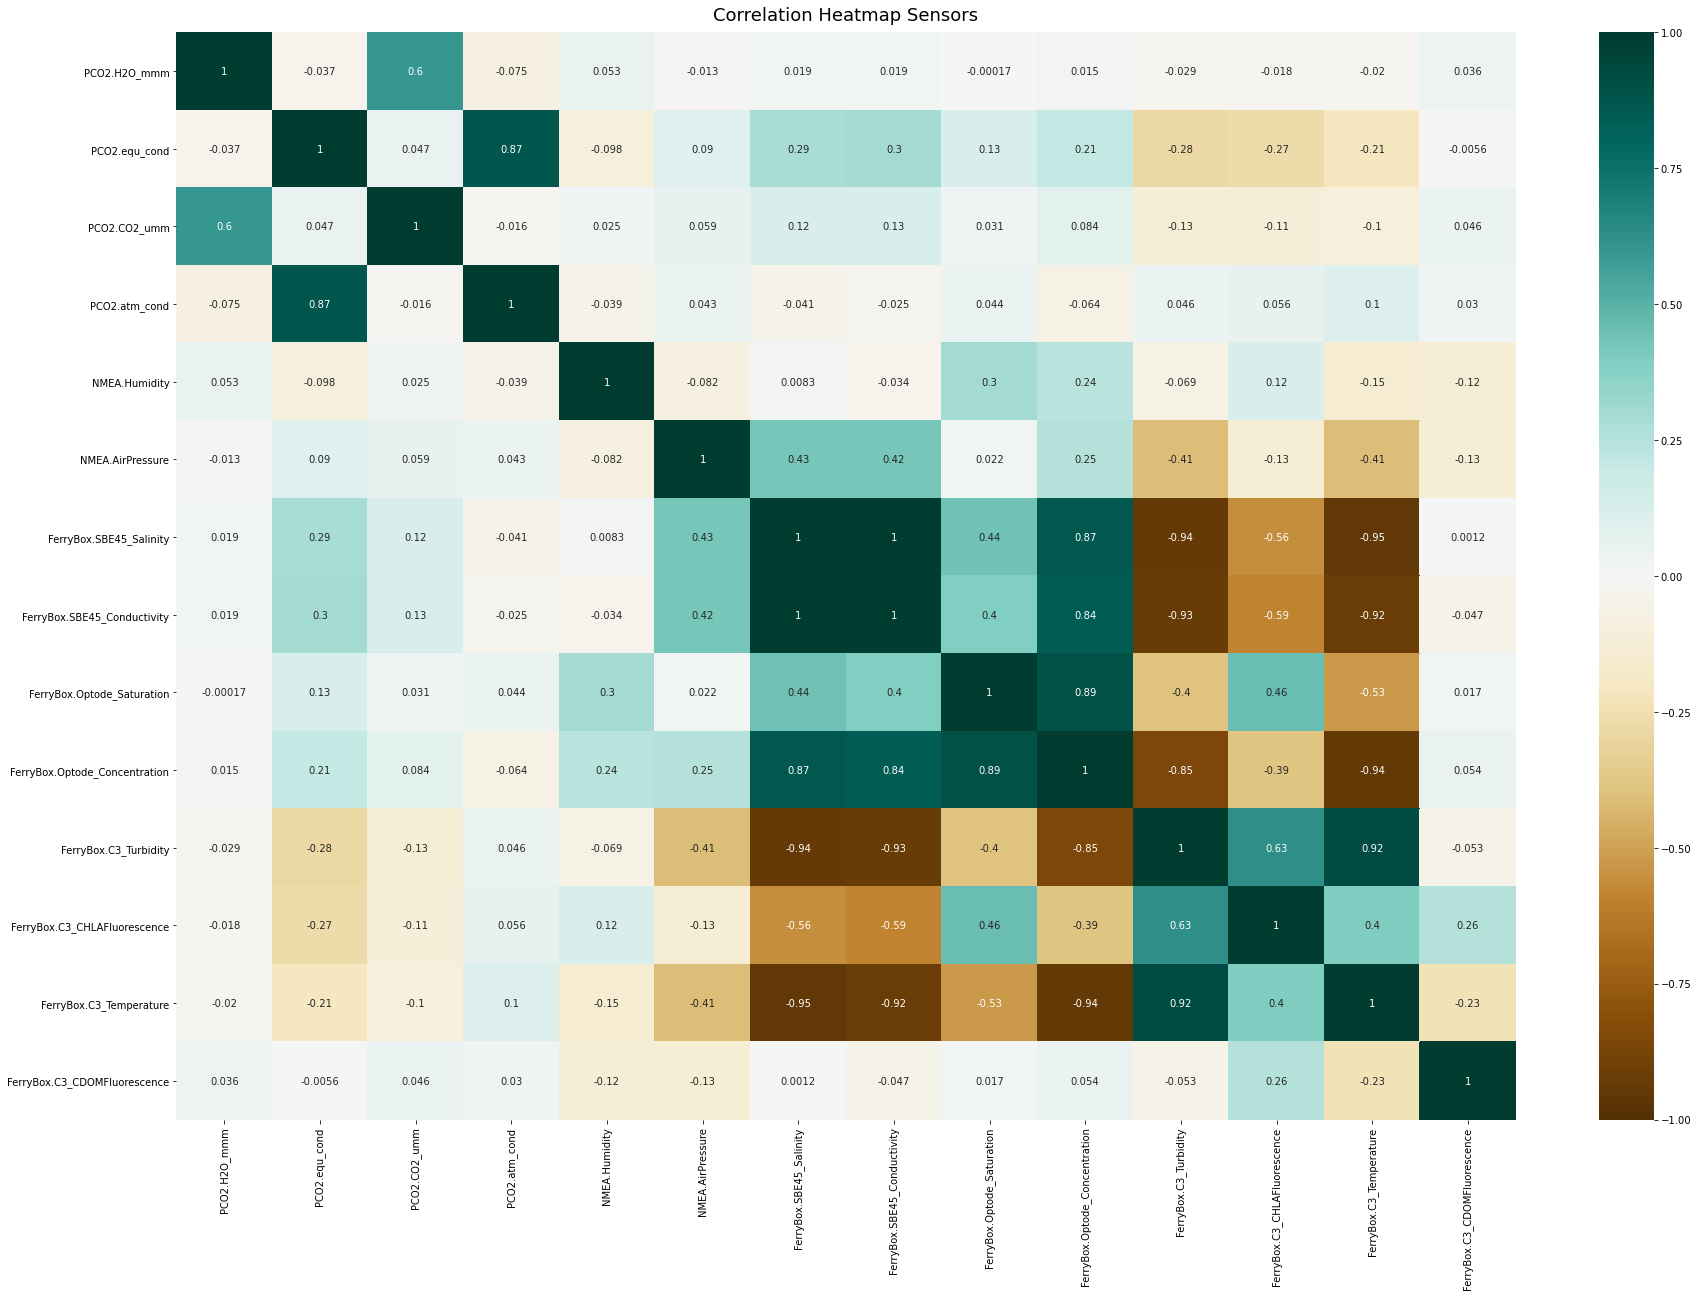

In [38]:
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = new_df.corr()
plt.figure(figsize=(30, 20))
heatmap = sn.heatmap(corrMatrix, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap Sensors', fontdict={'fontsize':18}, pad=12);
plt.show()

figure = heatmap.get_figure()   
figure.savefig('heatmap.png', dpi=300, bbox_inches='tight')


In [39]:
new_df.to_csv('out_sensors.csv')